In [ ]:
# https://www.youtube.com/watch?v=G0L8SN02clA

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np 
import gym 
from collections import deque
import random
import matplotlib.pyplot as plt

In [ ]:
class GenericNetwork(nn.Module):
    def __init__(self, lr ,input_dims, fc1_dims, fc2_dims, n_actions):
        super(GenericNetwork, self).__init__()

        self.lr = lr 
        self.input_dims = input_dims 
        self.fc1_dims = fc1_dims 
        self.fc2_dims = fc2_dims 
        self.n_actions = n_actions 

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims) 
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        state = T.tensor(state, dtype=T.float).to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
class Agent(object):
    def __init__(self, alpha, beta, input_dims, gamma=0.99, n_actions=2, layer1_size=64, layer2_size=64, n_outputs=1):
        """
        actor_output = 2: mean and variance
        critic_output = 1: estimation of value function
        """
        self.alpha = alpha 
        self.beta = beta
        self.input_dims = input_dims
        self.gamma = gamma 
        self.log_probs = None 

        self.n_outputs = n_outputs

        self.actor = GenericNetwork(alpha, input_dims, layer1_size, layer2_size, n_actions=n_actions)
        self.critic = GenericNetwork(beta, input_dims, layer1_size, layer2_size, n_actions=1)

    def choose_action(self, state):
        mu, sigma = self.actor.forward(state)
        sigma = T.exp(sigma)
        action_probs = T.distributions.Normal(mu, sigma)                         
        a_t = action_probs.sample(sample_shape=T.Size([self.n_outputs]))        # probs == action value
        self.log_probs = action_probs.log_prob(a_t).to(self.actor.device)       # log_probs == log of p(a|s)
        action = T.tanh(a_t)                                                    # bound the action value between -1 and 1
        return action.item()

    def learn(self, state, reward, new_state, done, I):
        self.actor.optimizer.zero_grad()                                        # You don't want the gradients from a previous sample to affect the calculation of the gradients from the current sample
        self.critic.optimizer.zero_grad()

        critic_value_next = self.critic.forward(new_state)
        critic_value = self.critic.forward(state)

        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)
        delta = reward + self.gamma * critic_value_next * (1 - int(done)) - critic_value

        critic_loss = I * delta**2
        actor_loss  = I * delta * -self.log_probs
        
        (actor_loss + critic_loss).backward()
        self.actor.optimizer.step()
        self.critic.optimizer.step()

In [ ]:
agent = Agent(alpha=0.000005, beta=0.000001, input_dims=[2], gamma=0.99, layer1_size=256, layer2_size=256)

# Input dimension == 2: car position and car velocity 

env = gym.make('MountainCarContinuous-v0')
NUM_EPISODES = 30 
GAMMA = 0.99

In [ ]:
score_history = []
I = 1

for i in range(NUM_EPISODES):
    done = False 
    score = 0 
    state = env.reset()
    I = I * GAMMA

    while not done:
        action = np.array(agent.choose_action(state)).reshape((1,))
        next_state, reward, done, info = env.step(action)
        agent.learn(state, reward, next_state, done, I)
        state = next_state 
        score = score + reward 
    
    score_history.append(score)
    print(f'epsiode: {i}, score: {score}')

Text(0.5, 1.0, 'MountainCarContinuous-v0')

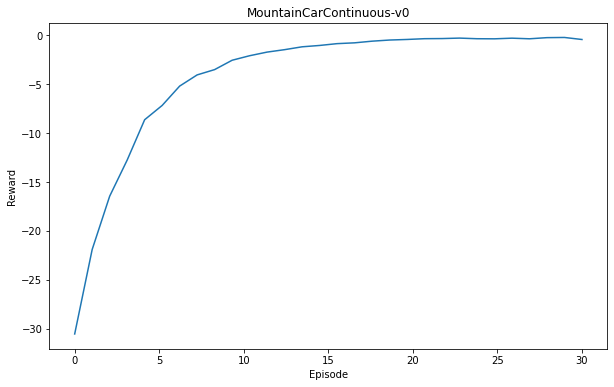

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.linspace(0, NUM_EPISODES, NUM_EPISODES)

ax.plot(x, score_history)

ax.set_xlabel("Episode")
ax.set_ylabel("Reward")
ax.set_title("MountainCarContinuous-v0")